In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import glob
from tqdm import tqdm

# Internal modules
from logger import logger
from constants import *
from parsers import get_info_table
from fileops import get_data_root, get_output_equivalent, get_data_folders, extract_reference_distributions, save_figs_book
from postpro import process_runids
from plotters import harmonize_axes_limits
from substitutors import StackSubstitutor
from correctors import LinRegCorrector

### Input parameters

In [3]:
# Get input data directory
dataroot = get_data_root()  # Root directory for raw data
submap = [
    (1, 0, None),
    (FrameIndex.STIM - 1, FrameIndex.STIM, NFRAMES_PER_TRIAL),
]
ss = StackSubstitutor(submap)
datadir = os.path.join(
    get_output_equivalent(dataroot, DataRoot.RAW, DataRoot.SUBSTITUTED),
    ss.code,
    'main'
)
logger.info(f'input data directory: "{datadir}"')

# Define input parameters
projfunc = 'median'  # Projection function to get reference image from 3D stack
sortkey = Label.RUNID  # Sort key for different files in the same dataset folder
lines = [  # Lines to analyze
    'pv', 
    'sst', 
    'line3',
]

# Figures dictionary
figsdir = get_output_equivalent(dataroot, DataRoot.RAW, DataRoot.FIG)
figs = {}

 2024/01/19 17:58:56: input data directory: "/gpfs/scratch/lemait01/data/usnm/substituted/submap_0<-1_9->10every100/main"


### Derived parameters

In [4]:
projfunc = {'mean': np.mean, 'median': np.median}[projfunc]

### Extract reference frame pixel distributions across lines, datasets, and runs 

In [5]:
# Loop over lines
ref_dists = []
for line in lines:
    # Get dataset folders in line subdirectory
    linedir = os.path.join(datadir, line)
    dataset_folders = get_data_folders(linedir)
    datasets = [os.path.basename(df) for df in dataset_folders]

    # Extract reference distributions from all datasets in line
    ref_dists.append(pd.concat(
        [extract_reference_distributions(folder, projfunc) for folder in dataset_folders],
        axis=0, keys=datasets, names=[Label.DATASET]
    ))

# Concatenate reference distributions from all lines
ref_dists = pd.concat(ref_dists, axis=0, keys=lines, names=[Label.LINE])
ref_dists    

 2024/01/19 17:58:59: Searching through /gpfs/scratch/lemait01/data/usnm/substituted/submap_0<-1_9->10every100/main/pv
 2024/01/19 17:58:59: found 10 folders containing TIF files
 2024/01/19 17:58:59: loading reference distributions from 20190702_mouse1_region1 folder
 2024/01/19 17:59:00: loading reference distributions from 20190703_mouse4_region1 folder
 2024/01/19 17:59:00: loading reference distributions from 20190629_mouse2_region1 folder
 2024/01/19 17:59:01: loading reference distributions from 20190702_mouse5_region1 folder
 2024/01/19 17:59:02: loading reference distributions from 20190630_mouse3_region1 folder
 2024/01/19 17:59:03: loading reference distributions from 20190821_mouse3_region1 folder
 2024/01/19 17:59:03: loading reference distributions from 20190821_mouse6_region1 folder
 2024/01/19 17:59:04: loading reference distributions from 20190606_mouse2_region1 folder
 2024/01/19 17:59:05: loading reference distributions from 20190821_mouse7_region1 folder
 2024/01/19

line   dataset                   file                                                   pixel
pv     20190702_mouse1_region1   pv_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-217.tif     0         88.0
                                                                                        1         89.0
                                                                                        2         89.0
                                                                                        3         89.0
                                                                                        4         90.0
                                                                                                 ...  
line3  20191023_mouse10_region1  line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-681.tif  65531    131.0
                                                                                        65532    130.0
                                                                                  

### Aggregate across runs 

In [7]:
agg_dists = ref_dists.groupby([Label.LINE, Label.DATASET, 'pixel']).mean()
agg_dists

line   dataset                  pixel
line3  20190704_mouse2_region1  0        96.468750
                                1        98.093750
                                2        97.250000
                                3        96.468750
                                4        96.500000
                                           ...    
sst    20190808_mouse8_region1  65531    84.133333
                                65532    84.200000
                                65533    83.466667
                                65534    83.400000
                                65535    83.266667
Name: intensity, Length: 3538944, dtype: float64

### Compute skewnesses and corresponding max quantiles

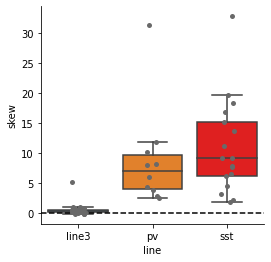

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.despine(ax=ax)
pltkwargs = dict(
    data=agg_skews.reset_index(),
    ax=ax,
    x=Label.LINE,
    y='skew',
)
sns.boxplot(palette=Palette.LINE, showfliers=False, **pltkwargs)
sns.stripplot(color='dimgray', **pltkwargs)
ax.axhline(0, color='k', linestyle='--');

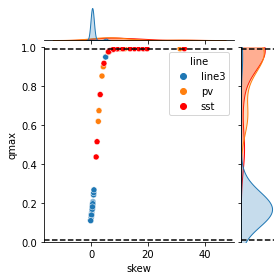

In [8]:
# Compute corresponding skewness
agg_skews = agg_dists.groupby([Label.LINE, Label.DATASET]).agg(skew).rename('skew')

# Compute corresponding qmax
agg_qmaxs = LinRegCorrector.skew_to_qmax(agg_skews).rename('qmax')

# Plot qmax vs skewness
df = pd.concat([agg_skews, agg_qmaxs], axis=1)
g = sns.jointplot(
    df, 
    x='skew',
    y='qmax',
    height=4,
    hue=Label.LINE,
    palette=Palette.LINE,
    marginal_kws=dict(
        common_norm=False),
)
g.ax_joint.set_ylim(0, 1)
qbounds = LinRegCorrector.skew_to_qmax(np.array([-np.inf, np.inf]))
for qb in qbounds:
    for ax in [g.ax_joint, g.ax_marg_y]:
        ax.axhline(qb, color='k', linestyle='--')

### Plot pixel distributions across lines, & datasets

 2024/01/19 18:01:20: plotting distributions for line3 line
 2024/01/19 18:01:33: plotting distributions for pv line
 2024/01/19 18:01:36: plotting distributions for sst line


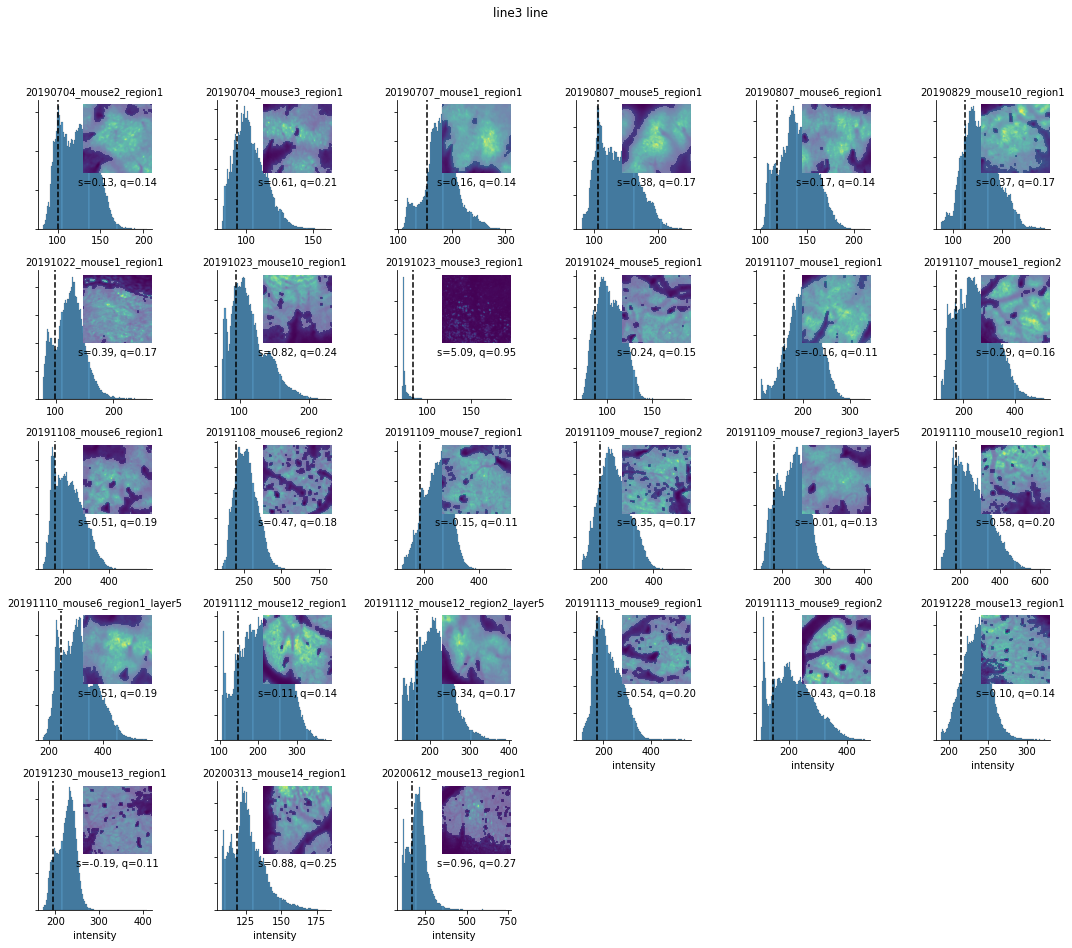

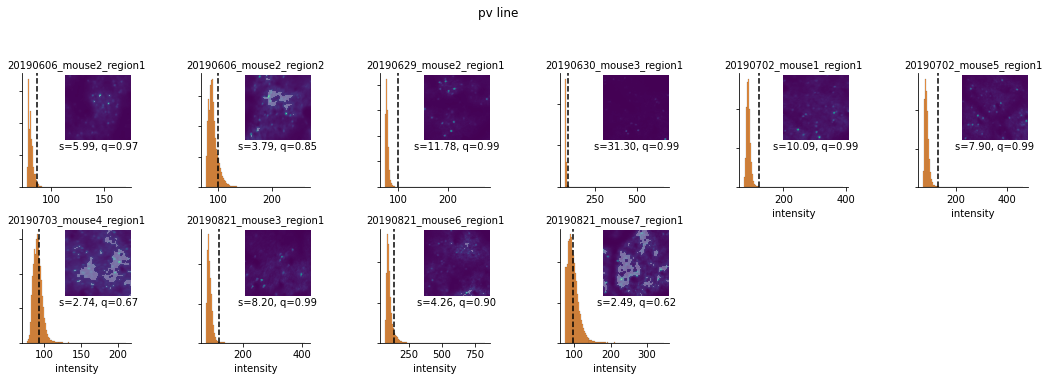

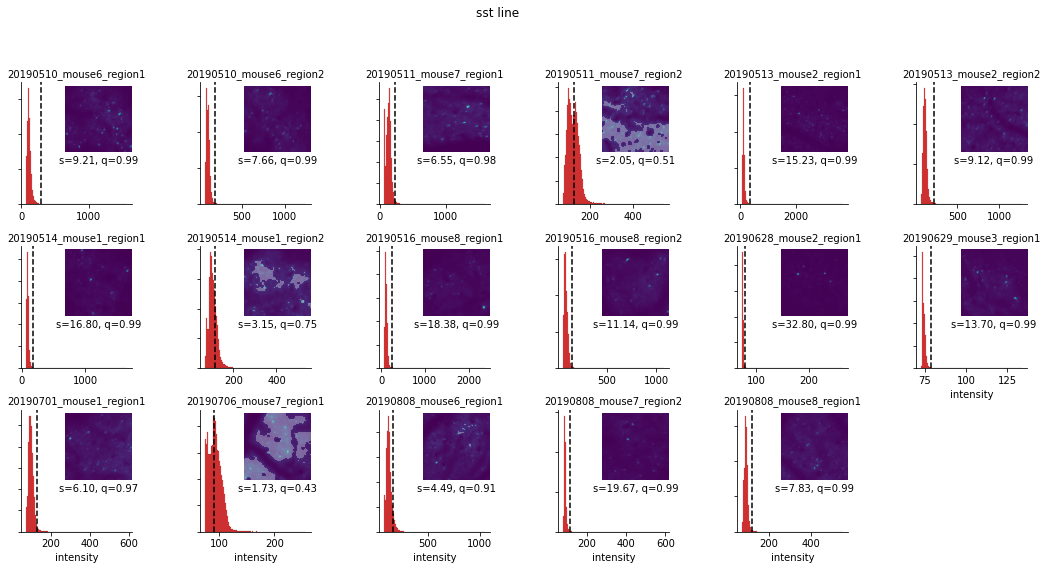

In [9]:
# For each line
for line, gdists in agg_dists.groupby('line'):
    logger.info(f'plotting distributions for {line} line')
    # Generate facetgrid of distributions per dataset
    fg = sns.FacetGrid(
        data=gdists.reset_index(),
        col=Label.DATASET,
        col_wrap=6,
        height=2.5,
        sharex=False,
        sharey=False,
    )
    fg.set_titles('{col_name}', fontsize=10)
    fg.figure.suptitle(f'{line} line', y=1.05)

    # Plot histrogram distributions of pixel intensities for each dataset 
    fg.map(
        sns.histplot,
        'intensity',
        bins=100,
        color=Palette.LINE[line],
    )

    # Loop over datasets
    for dataset, ddist in gdists.groupby('dataset'):
        # Extract axis
        ax = fg.axes_dict[dataset]

        # Remove y-axis labels
        ax.set_ylabel('')
        for label in ax.get_yticklabels():
            label.set_visible(False)
        
        # Extract image from distribution, and plot it in inset
        relxy = 0.6
        n = int(np.sqrt(len(ddist)))
        frame = np.flipud(np.reshape(ddist.values, (n, n)))
        axins = ax.inset_axes([1 - relxy, 1 - relxy, relxy, relxy])
        axins.imshow(frame, cmap='viridis')
        axins.axis('off')

        # Extract skewness and compute corresponding qmax
        s = agg_skews.loc[line, dataset]
        qmax = LinRegCorrector.skew_to_qmax(s)

        # Annotate skewness and qmax
        ax.text(
            1 - relxy / 2, 1 - relxy,
            f's={s:.2f}, q={qmax:.2f}', 
            transform=ax.transAxes,
            ha='center',
            va='top',
        )

        # Compute corresponding Imax 
        Imax = ddist.quantile(qmax)

        # Plot Imax on distribution
        ax.axvline(Imax, color='k', linestyle='--')

        # Apply corresponding mask to image
        mask = frame <= Imax
        masked = np.ma.masked_where(mask, mask)
        axins.imshow(masked, alpha=.3, cmap='gray_r')

### Compute and plot skewness of each distribution

 2024/01/18 14:27:44: computing skewness for each reference distribution
 2024/01/18 14:28:02: plotting skewness distributions for line3 line
 2024/01/18 14:28:02: plotting skewness distributions for pv line
 2024/01/18 14:28:02: plotting skewness distributions for sst line
 2024/01/18 14:28:02: plotting adatset-averaged skewness distributions across lines


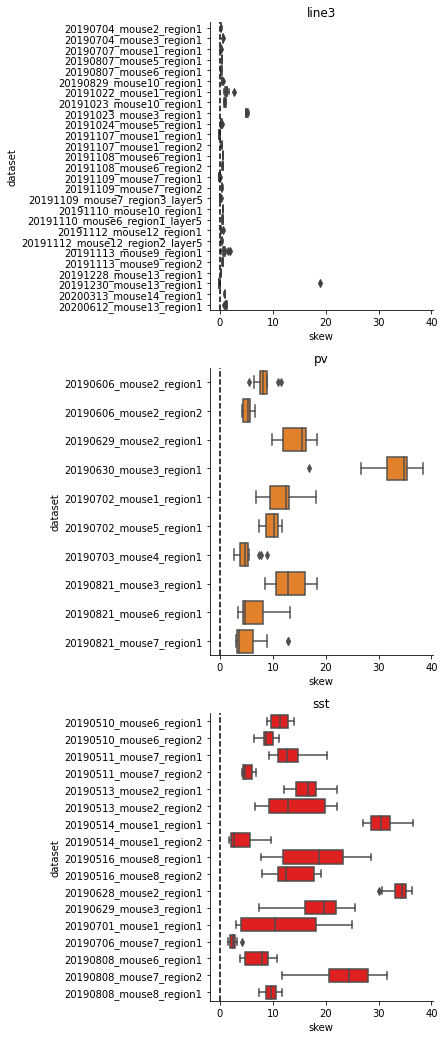

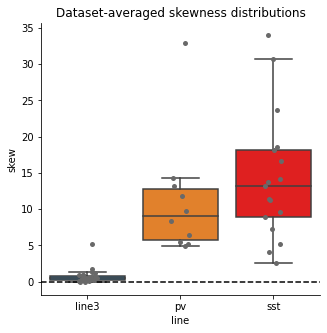

In [6]:
# Compute skewness for each ref dist
logger.info('computing skewness for each reference distribution')
skews = (ref_dists
    .groupby([Label.LINE, Label.DATASET, 'file'])
    .agg(skew)
    .rename('skew')
)

# Plot skewness distributions across lines, datasets, and runs
figs['skewness per file across datasets'], axes = plt.subplots(len(lines), 1, figsize=(4, len(lines) * 6))
for ax, (line, lskews) in zip(axes, skews.groupby(Label.LINE)):
    sns.despine(ax=ax)
    logger.info(f'plotting skewness distributions for {line} line')
    sns.boxplot(
        data=lskews.reset_index(),
        ax=ax,
        y=Label.DATASET,
        x='skew',
        color=Palette.LINE[line],
    )
    ax.set_title(line)
    ax.axvline(0, color='k', linestyle='--')
harmonize_axes_limits(axes, axkey='x')

# Plot dataset-averaged skewness distributions across lines 
logger.info(f'plotting adatset-averaged skewness distributions across lines')
aggskews = skews.groupby([Label.LINE, Label.DATASET]).mean()
figs['skewness per dataset across lines'], ax = plt.subplots(figsize=(5, 5))
ax.set_title('Dataset-averaged skewness distributions')
sns.despine(ax=ax)
pltkwargs = dict(
    data=aggskews.reset_index(),
    ax=ax,
    x=Label.LINE,
    y='skew',
)
sns.boxplot(palette=Palette.LINE, showfliers=False, **pltkwargs)
sns.stripplot(color='dimgray', **pltkwargs)
ax.axhline(0, color='k', linestyle='--');

### Define skewness to qmax function

 2024/01/18 14:37:06: LinRegCorrector(robust=False, no intercept, qmax=adaptive)


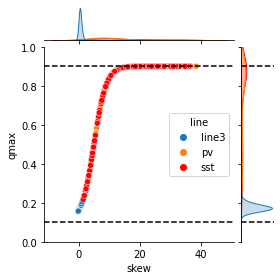

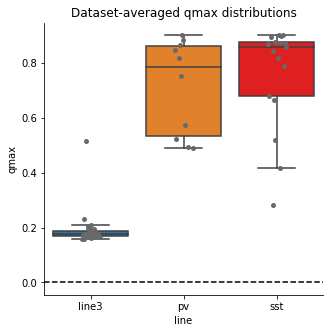

In [12]:
# Define linear corrector object with adaptive qmax
lrc = LinRegCorrector(qmax='adaptive')
logger.info(lrc)

qmaxs = lrc.skew_to_qmax(skews).rename('qmax')
df = pd.concat([skews, qmaxs], axis=1)
g = sns.jointplot(
    df, 
    x='skew',
    y='qmax',
    height=4,
    hue=Label.LINE,
    palette=Palette.LINE,
    marginal_kws=dict(
        common_norm=False),
)
g.ax_joint.set_ylim(0, 1)
qbounds = lrc.skew_to_qmax(np.array([-np.inf, np.inf]))
for qb in qbounds:
    for ax in [g.ax_joint, g.ax_marg_y]:
        ax.axhline(qb, color='k', linestyle='--')

aggqmaxs = qmaxs.groupby([Label.LINE, Label.DATASET]).mean()
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Dataset-averaged qmax distributions')
sns.despine(ax=ax)
pltkwargs = dict(
    data=aggqmaxs.reset_index(),
    ax=ax,
    x=Label.LINE,
    y='qmax',
)
sns.boxplot(palette=Palette.LINE, showfliers=False, **pltkwargs)
sns.stripplot(color='dimgray', **pltkwargs)
ax.axhline(0, color='k', linestyle='--');

### Plot FOVs and pixels selection for specific datasets

 2024/01/18 14:28:08: extracting ref. distribution for line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-726.tif file
 2024/01/18 14:28:08: selecting 10348/65536 pixels within quantile range 0.000 - 0.155
 2024/01/18 14:28:08: extracting ref. distribution for line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-727.tif file
 2024/01/18 14:28:08: selecting 10322/65536 pixels within quantile range 0.000 - 0.155
 2024/01/18 14:28:08: extracting ref. distribution for line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-725.tif file
 2024/01/18 14:28:08: selecting 10367/65536 pixels within quantile range 0.000 - 0.155
 2024/01/18 14:28:08: extracting ref. distribution for line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-724.tif file
 2024/01/18 14:28:08: selecting 10872/65536 pixels within quantile range 0.000 - 0.160
 2024/01/18 14:28:08: extracting ref. distribution for line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-723.tif file
 2024/01/18 14:28:08: selecting 10453/65536 pixels within quantile range 0.000 - 

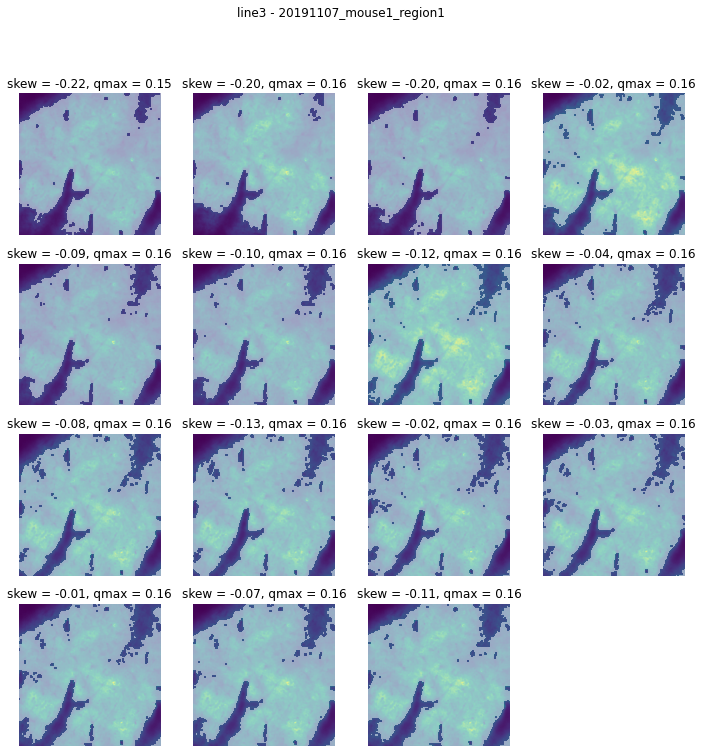

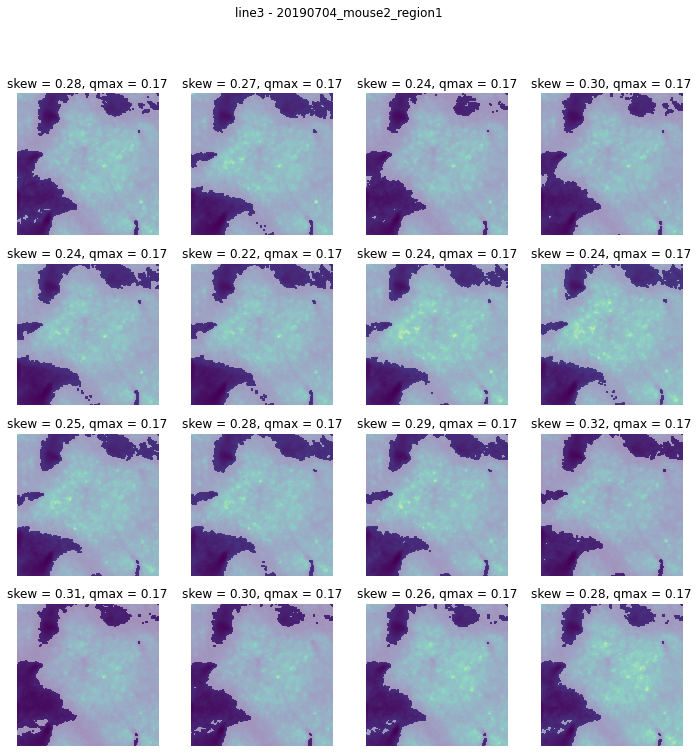

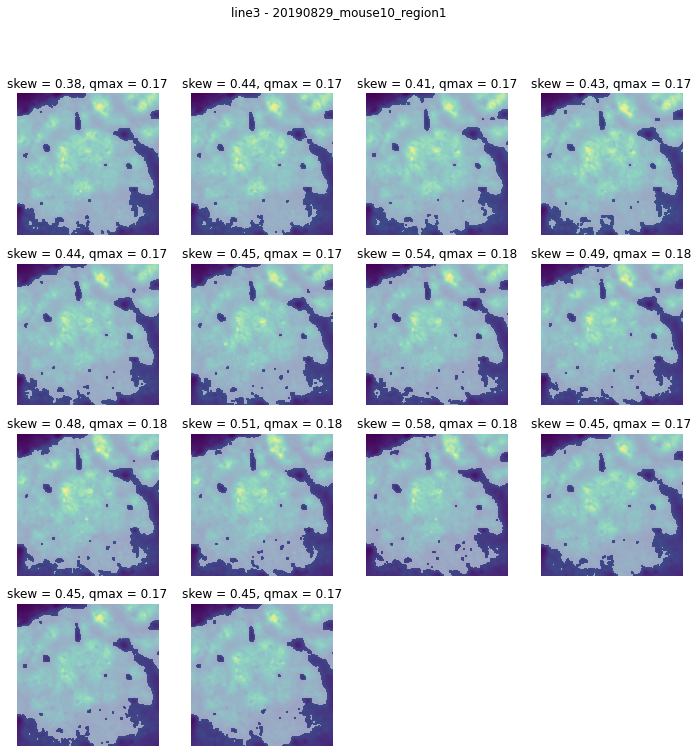

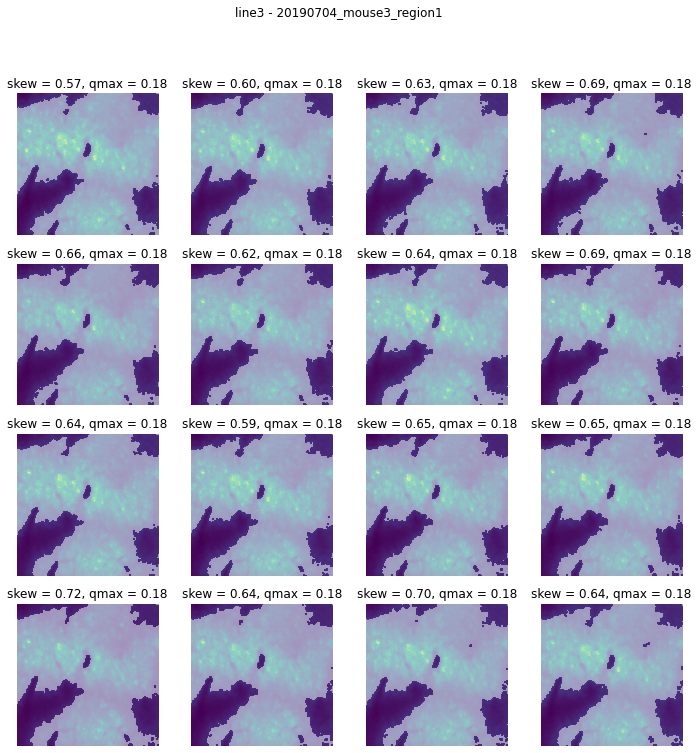

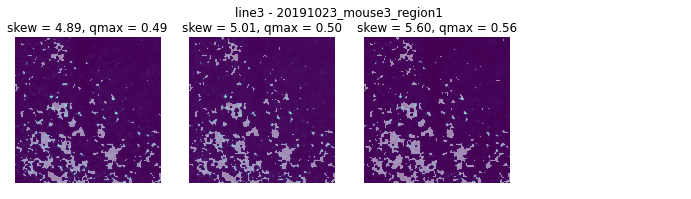

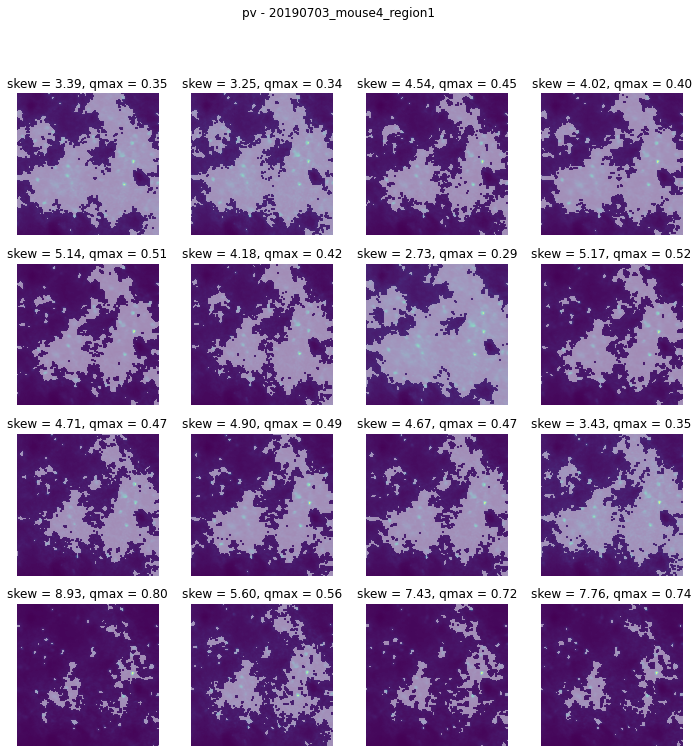

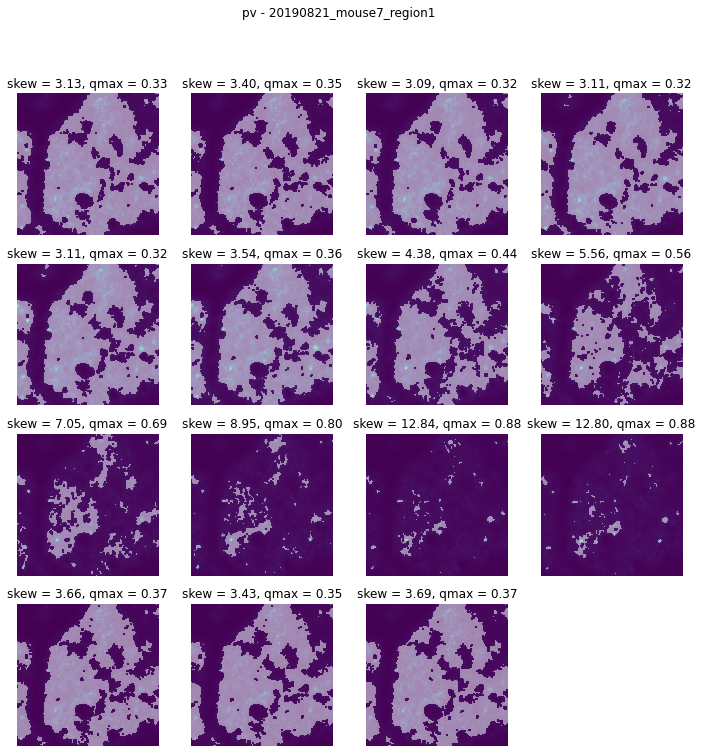

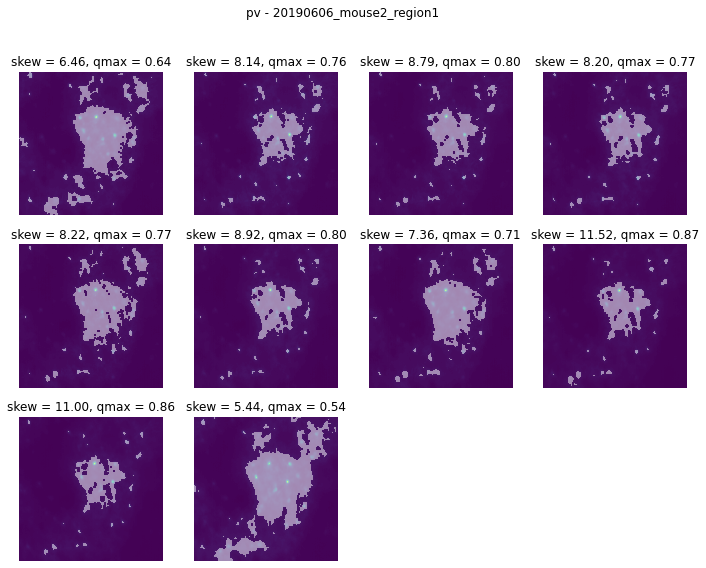

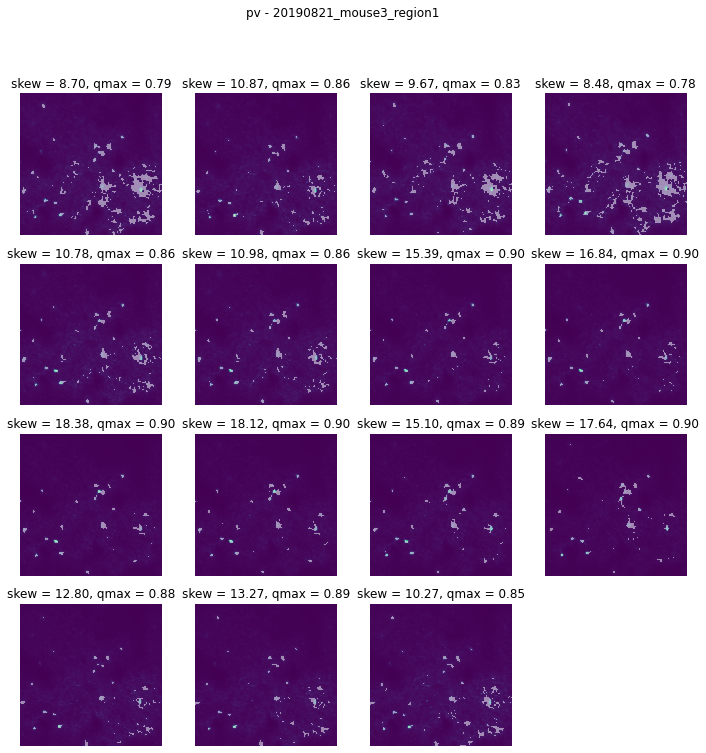

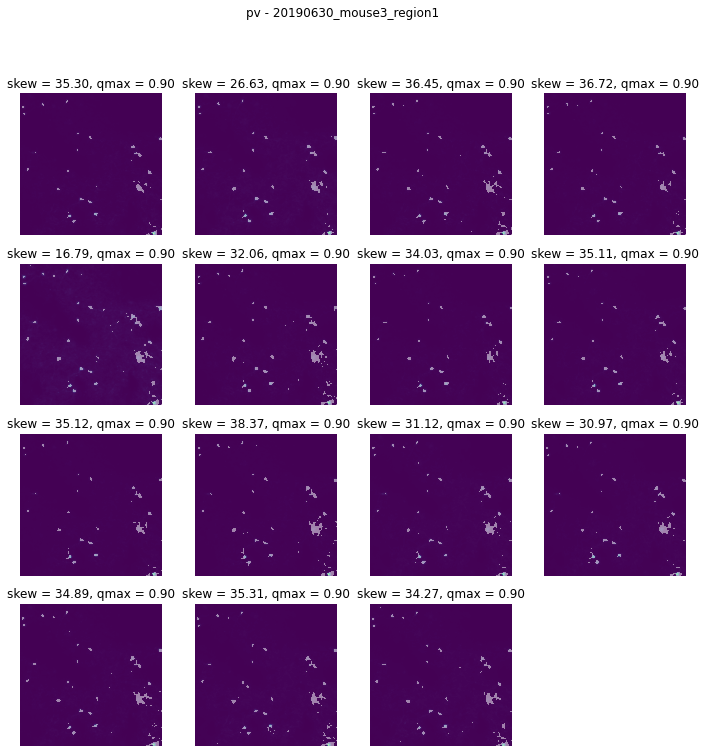

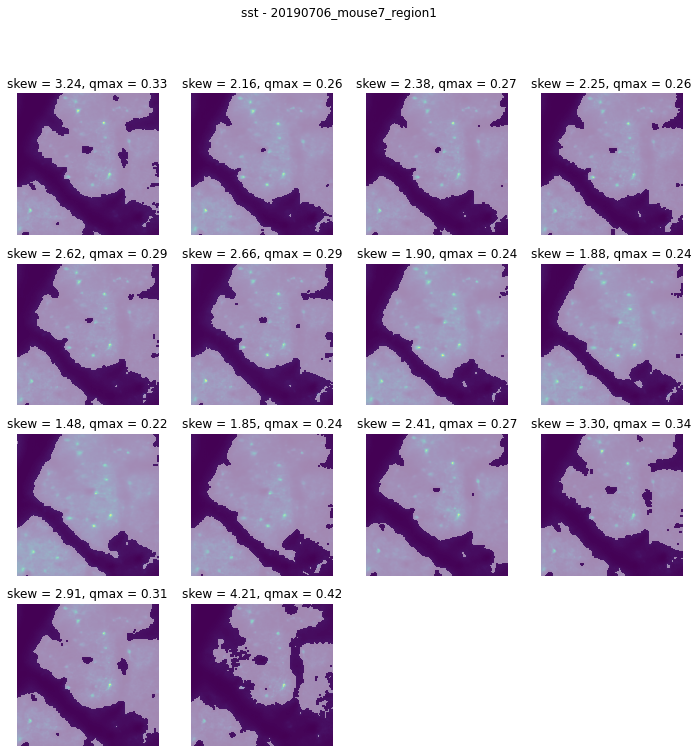

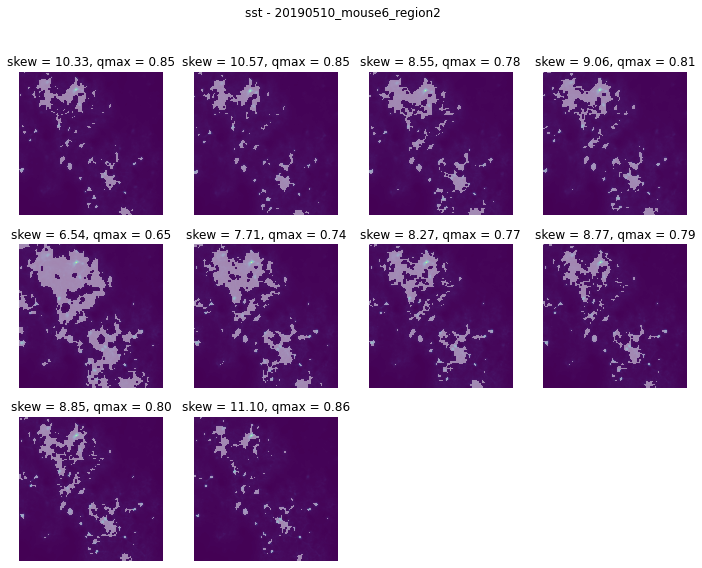

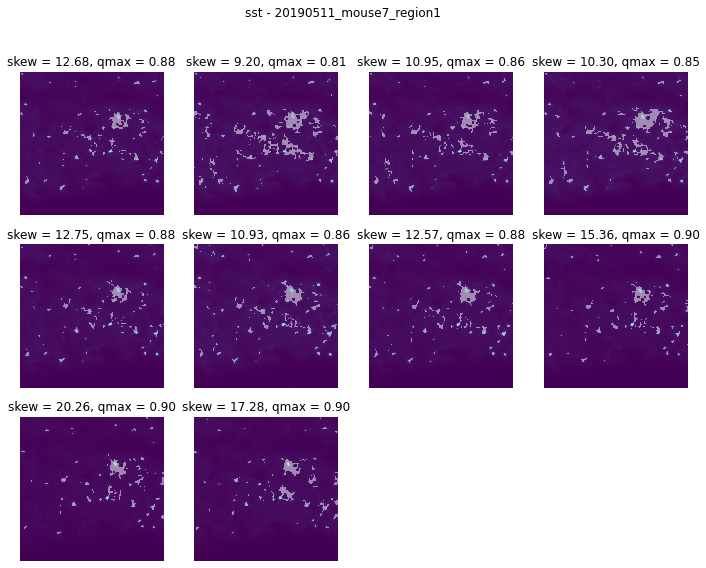

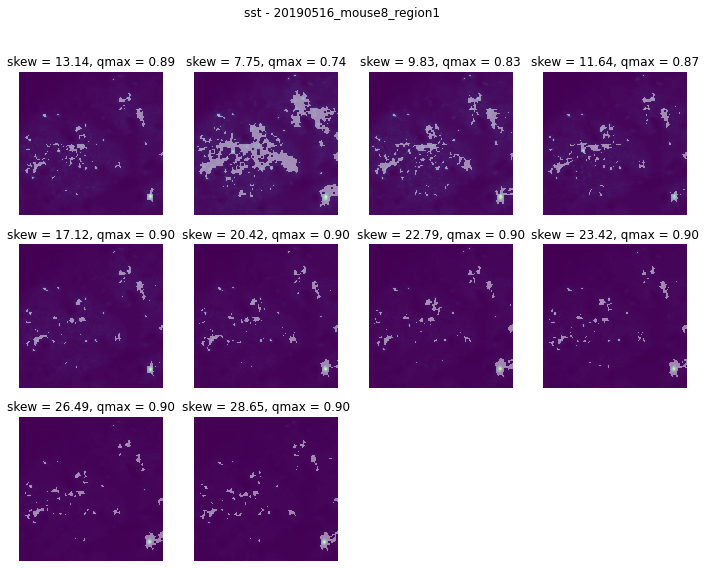

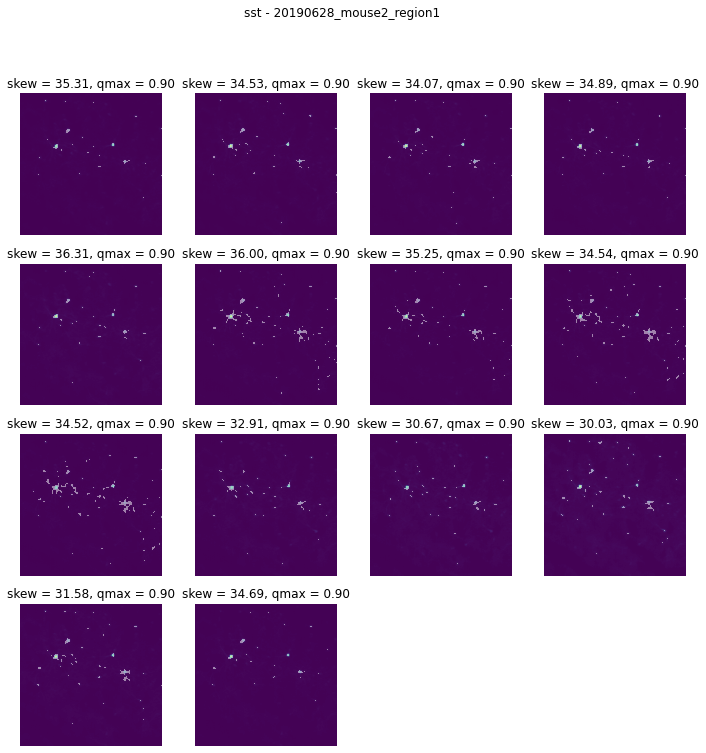

In [8]:
# Number of datasets to plot per line
ngraphs = 5

# Lopp through lines
for line, gdata in aggskews.groupby(Label.LINE):
    lineaggskews = gdata.droplevel(Label.LINE)

    # Select dataset with aggregated skewnesses values evenly spaced along the distribution quantiles
    target_skews = lineaggskews.quantile(np.linspace(0, 1, ngraphs))
    target_idxs = [(lineaggskews - ts).abs().argmin() for ts in target_skews]
    datasets = lineaggskews.iloc[target_idxs].index.values

    # For each dataset,
    for dataset in datasets:
        # Extract dataset reference distributions
        dataset_dists = ref_dists.loc[pd.IndexSlice[line, dataset, :]]

        # Group by file
        groups = dataset_dists.groupby('file')

        # Create figure
        naxes = groups.ngroups
        col_wrap = 4
        nrows, ncols = int(np.ceil(naxes / col_wrap)), col_wrap
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
        for ax in axes.ravel():
            ax.axis('off')
        fig.suptitle(f'{line} - {dataset}')

        # Loop over files
        for ax, (file, dist) in zip(axes.ravel(), groups):
            logger.info(f'extracting ref. distribution for {file} file')

            # Extract distribution and reshape to image
            n = int(np.sqrt(len(dist)))
            frame = np.flipud(np.reshape(dist.values, (n, n)))

            # Compute skewness and maximum selection quantile
            s = skew(dist)
            qmax = lrc.skew_to_qmax(s)
            ax.set_title(f'skew = {s:.2f}, qmax = {qmax:.2f}')

            # Plot image with pixels above selection quantile grayed out
            lrc.plot_frame(frame, ax=ax)

### Save output figures

In [13]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix='skewness')

 2024/01/18 14:38:58: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2024.01.18/figs_skewness.pdf:


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]
